In [1]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

In [2]:
# Dataloaders for all experiments

from torchvision.transforms import Compose, Resize, ToTensor, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, SubsetRandomSampler

class NoisyMNIST(MNIST):
    """A subclass of MNIST dataset to add Gaussian noise to the images."""
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, noise_std=0):
        super().__init__(root=root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.noise_std = noise_std

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        if self.noise_std > 0:
            noise = torch.randn_like(img) * self.noise_std
            img = torch.clamp(img + noise, 0, 1)
        return img, target

def create_dataloaders(dataset, indices, batch_size):
    """Utility function to create DataLoader from indices."""
    sampler = SubsetRandomSampler(indices)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)


def index_for_classes(dataset, target_classes):
    """Create an index for the dataset to filter by specific target classes."""
    idx = torch.zeros_like(dataset.targets, dtype=torch.bool)
    for target in target_classes:
        idx |= dataset.targets == target
    return idx

def split_dataloaders(classes_list, batch_size=256, input_noise_std=0):
    """Generate data loaders for training and testing for specific class splits."""
    base_transform = Compose([Resize((28, 28)),ToTensor()])
    trainset = NoisyMNIST(root="./data", train=True, download=True, transform=base_transform, noise_std=input_noise_std)
    testset = NoisyMNIST(root="./data", train=False, download=True, transform=base_transform)

    dataloaders = []
    for classes in classes_list:
        train_idx = torch.where(index_for_classes(trainset, classes))[0]
        test_idx = torch.where(index_for_classes(testset, classes))[0]
        train_loader = create_dataloaders(trainset, train_idx, batch_size)
        test_loader = create_dataloaders(testset, test_idx, batch_size)
        dataloaders.append((train_loader, test_loader))

    return dataloaders

def permuted_dataloaders(num_tasks, batch_size=256, input_noise_std=0):
    """Generate data loaders for training and testing with permuted pixels across tasks."""
    dataloaders = []
    for task in range(num_tasks):
        perm_transform = Compose([
            Resize((28, 28)),
            ToTensor(),
            Lambda(lambda x, idx=torch.from_numpy(np.random.RandomState(task).permutation(784)): x.view(-1)[idx].view(1, 28, 28))
        ]) if task > 0 else Compose([Resize((28, 28)), ToTensor()])

        dataset = lambda train: NoisyMNIST(root="./data", train=train, download=True, transform=perm_transform, noise_std=input_noise_std)
        train_loader = DataLoader(dataset(True), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset(False), batch_size=batch_size, shuffle=True)
        dataloaders.append((train_loader, test_loader))

    return dataloaders



In [3]:
# Retrieving random coresets

def extract_coreset(train_loader, num_samples=200, permute_all=False):
    if permute_all:
        shuffled_indices = torch.randperm(len(train_loader.dataset))
    else:
        task_indices = train_loader.sampler.indices
        shuffled_indices = task_indices[torch.randperm(len(task_indices))]

    coreset_indices = shuffled_indices[:num_samples]
    remaining_indices = shuffled_indices[num_samples:]

    # Create a new DataLoader for the coreset
    coreset_sampler = SubsetRandomSampler(coreset_indices)
    coreset_loader = DataLoader(
        train_loader.dataset,
        batch_size=train_loader.batch_size,
        sampler=coreset_sampler
    )

    return coreset_loader, remaining_indices

def coreset_split(coresets, train_loader, num_samples=200):
    coreset_loader, remaining_indices = extract_coreset(train_loader, num_samples, permute_all=False)
    train_loader.sampler.indices = remaining_indices
    coresets.append(coreset_loader)

def coreset_permuted(coresets, train_loader, num_samples=200):
    coreset_loader, _ = extract_coreset(train_loader, num_samples, permute_all=True)
    coresets.append(coreset_loader)

In [24]:
# Implement model layers

import torch.nn.functional as F
from torch.nn import Parameter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def kl_divergence(mu1, sigma1, mu2, sigma2):
    sigma_ratio = sigma1 / sigma2
    term1 = torch.log(sigma_ratio)
    term2 = (sigma2 / sigma1).pow(2)
    term3 = ((mu1 - mu2) / sigma1).pow(2)
    kl = 0.5 * (2 * term1 - 1 + term2 + term3).sum()
    return kl

class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, priors=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias

        default_priors = {'prior_mu': 0, 'prior_sigma': 0.01}
        priors = priors if priors is not None else default_priors

        self.prior_W_mu = torch.tensor(priors['prior_mu'])
        self.prior_W_sigma = torch.tensor(priors['prior_sigma'])
        self.prior_bias_mu = torch.tensor(priors['prior_mu'])
        self.prior_bias_sigma = torch.tensor(priors['prior_sigma'])

        self.W_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.W_rho = nn.Parameter(torch.Tensor(out_features, in_features))

        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.Tensor(out_features))
            self.bias_rho = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(0, 0.1)
        self.W_rho.data.fill_(-3)

        if self.use_bias:
            self.bias_mu.data.normal_(0, 0.1)
            self.bias_rho.data.fill_(-3)

    def forward(self, x, sample=True):
        self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        self.bias_sigma = torch.log1p(torch.exp(self.bias_rho)) if self.use_bias else 0

        act_mu = F.linear(x, self.W_mu, self.bias_mu)
        act_var = 1e-16 + F.linear(x ** 2, self.W_sigma ** 2, self.bias_sigma ** 2 if self.use_bias else None)
        act_std = torch.sqrt(act_var)

        if self.training or sample:
            eps = torch.randn_like(act_mu)
            return act_mu + act_std * eps
        return act_mu

    def kl_loss(self):
        kl = kl_divergence(self.prior_W_mu, self.prior_W_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += kl_divergence(self.prior_bias_mu, self.prior_bias_sigma, self.bias_mu, self.bias_sigma)
        return kl

In [21]:
# Implement VCL models for SplitMNIST

class BaseSplitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(784, 256)
        self.fc2 = Linear(256, 256)
        self.classifiers = nn.ModuleList([Linear(256, 2) for i in range(5)])

    def forward(self, x, task_id):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.classifiers[task_id](x)

    def get_kl(self, task_id):
        return self.fc1.kl_loss() + self.fc2.kl_loss() + self.classifiers[task_id].kl_loss()

    def update_prior(self):
         for layer in [self.fc1, self.fc2]:
            layer.prior_W_mu = layer.W_mu.data
            layer.prior_W_sigma = layer.W_sigma.data
            if layer.use_bias:
                layer.prior_bias_mu = layer.bias_mu.data
                layer.prior_bias_sigma = layer.bias_sigma.data

class DropoutSplitModel(BaseSplitModel):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x, task_id):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.classifiers[task_id](x)


In [22]:
# Implement model for Permuted MNIST

class BasePermutedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(784, 100)
        self.fc2 = Linear(100, 100)
        self.classifier = Linear(100, 10)

    def forward(self, x, task_id):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.classifier(x)

    def get_kl(self, task_id):
        return self.fc1.kl_loss() + self.fc2.kl_loss() + self.classifier.kl_loss()

    def update_prior(self):
        for layer in [self.fc1, self.fc2]:
            layer.prior_W_mu = layer.W_mu.data
            layer.prior_W_sigma = layer.W_sigma.data
            if layer.use_bias:
                layer.prior_bias_mu = layer.bias_mu.data
                layer.prior_bias_sigma = layer.bias_sigma.data

class DropoutPermutedModel(BasePermutedModel):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x, task_id):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.classifier(x)

In [7]:
# Implement VCL

from tqdm import tqdm
from torch.optim import Adam


class ELBO(nn.Module):
    def __init__(self, model, train_size, beta):
        super().__init__()
        self.num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        self.beta = beta
        self.train_size = train_size

    def forward(self, outputs, targets, kl):
        return F.nll_loss(outputs, targets, reduction='mean') + self.beta * kl / self.num_params

def calculate_accuracy(outputs, targets):
    predicted_labels = outputs.argmax(dim=-1).cpu().numpy()
    return np.mean(predicted_labels == targets.cpu().numpy())

def train(model, num_epochs, dataloader, single_head, task_id, beta, param_noise, param_noise_std, T=10, replay=False):
    beta = 0 if replay else beta
    lr_start = 1e-3

    offset, output_nodes = (0, 10) if single_head else (task_id * model.classifiers[0].out_features, model.classifiers[0].out_features)
    train_size = len(dataloader.dataset) if single_head else dataloader.sampler.indices.shape[0]
    elbo = ELBO(model, train_size, beta)
    optimizer = Adam(model.parameters(), lr=lr_start)

    model.train()
    for _ in tqdm(range(num_epochs)):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            targets -= offset

            outputs = torch.zeros(inputs.shape[0], output_nodes, T, device=device)
            for i in range(T):
                net_out = model(inputs, task_id)
                outputs[:, :, i] = F.log_softmax(net_out, dim=-1)

            log_output = torch.logsumexp(outputs, dim=-1) - np.log(T)
            kl = model.get_kl(task_id)
            loss = elbo(log_output, targets, kl)
            loss.backward()

            if param_noise:
                with torch.no_grad():
                    for param in model.parameters():
                        if param.requires_grad:
                            param.add_(torch.randn_like(param) * param_noise_std)

            optimizer.step()


def predict(model, dataloader, single_head, task_id, T=10):
    offset, output_nodes = (0, 10) if single_head else (task_id * model.classifiers[0].out_features, model.classifiers[0].out_features)

    model.eval()
    accs = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets -= offset

            outputs = torch.zeros(inputs.shape[0], output_nodes, T, device=device)
            for i in range(T):
                net_out = model(inputs, task_id)
                outputs[:, :, i] = F.log_softmax(net_out, dim=-1)

            log_output = torch.logsumexp(outputs, dim=-1) - np.log(T)
            accs.append(calculate_accuracy(log_output, targets))

    return np.mean(accs)


def run_vcl(num_tasks, single_head, num_epochs, dataloaders, model,
            coreset_method, coreset_size=0, beta=1, update_prior=True, param_noise=False, param_noise_std=0.01):
    assert single_head or 10 // num_tasks == 10 / num_tasks

    coreset_list = []
    all_accs = np.full((num_tasks, num_tasks), np.nan)

    for task_id in range(num_tasks):
        print(f"Starting Task {task_id + 1}")

        trainloader, testloader = dataloaders[task_id]
        train(model, num_epochs, trainloader, single_head, task_id, beta, param_noise, param_noise_std)
        print(f"Done Training Task {task_id + 1}")

        if coreset_size > 0:
            coreset_method(coreset_list, trainloader, num_samples=coreset_size)

            for task in range(task_id + 1):
                print(f"Replaying Task {task + 1}")
                train(model, num_epochs, coreset_list[task], single_head, task, beta, param_noise, param_noise_std, replay=True)
        print()

        for task in range(task_id + 1):
            _, testloader_i = dataloaders[task]
            accuracy = predict(model, testloader_i, single_head, task)
            print(f"Task {task + 1} Accuracy: {accuracy}")
            all_accs[task_id][task] = accuracy
        print()

        if update_prior:
            model.update_prior()

    print(all_accs)
    return all_accs

In [8]:
random.seed(2)
torch.manual_seed(2)
np.random.seed(2)

In [25]:
# SPLIT MNIST EXPERIMENT
num_tasks = 5
num_epochs = 10
single_head = False
batch_size = 256

class_distribution = [
    [0, 1],
    [2, 3],
    [4, 5],
    [6, 7],
    [8, 9],
]
dataloaders = split_dataloaders(
    class_distribution, batch_size)
model = BaseSplitModel()
model = model.to(device)


# Baseline Coreset VCL
print("Baseline Coreset VCL")
coreset_size = 200
coreset_method = coreset_split
s_base_accs = run_vcl(num_tasks, single_head, num_epochs, dataloaders,
                      model, coreset_method, coreset_size, beta=0.01)

# Noisy Params VCL
param_std = [0.0001, 0.001, 0.01, 0.1]
s_param_accs = []
for std in param_std:
  print("Noisy Params VCL, STD {}".format(std))
  model = BaseSplitModel()
  model = model.to(device)
  s_param_accs.append(run_vcl(num_tasks, single_head, num_epochs, dataloaders,
              model, coreset_method, coreset_size, beta=0.01, param_noise=True, param_noise_std=std))

# Noisy Input MNIST
input_std = [0.0001, 0.001, 0.01, 0.1]
s_input_accs = []
for std in input_std:
  dataloaders = split_dataloaders(
    class_distribution, batch_size, std)

  print("\n\nNoisy Input VCL, STD {}".format(std))
  model = BaseSplitModel()
  model = model.to(device)
  s_input_accs.append(run_vcl(num_tasks, single_head, num_epochs, dataloaders,
              model, coreset_method, coreset_size, beta=0.01))

# VCL with dropout
dropout_probs = [0.0001, 0.001, 0.01, 0.1]
s_dropout_accs = []
for prob in dropout_probs:
  dropout_model = DropoutSplitModel(prob)
  dropout_model = model.to(device)

  print("\n\nDropout VCL, probability {}".format(prob))
  s_dropout_accs.append(run_vcl(num_tasks, single_head, num_epochs, dataloaders,
              dropout_model, coreset_method, coreset_size, beta=0.01))




Baseline Coreset VCL
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.00it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.59it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.64it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.9931171875

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.50s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.62it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.76it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.29it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.983328125
Task 3 Accuracy: 0.998046875

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.62it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.62it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.66it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.24it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.978421875
Task 3 Accuracy: 0.99853515625
Task 4 Accuracy: 0.99658203125

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.10it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.05it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.00it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.89it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.04it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.97059765625
Task 3 Accuracy: 0.99755859375
Task 4 Accuracy: 0.99609375
Task 5 Accuracy: 0.9918551619764397

[[0.99956597        nan        nan        nan        nan]
 [0.99913194 0.99311719        nan        nan        nan]
 [0.99956597 0.98332812 0.99804688        nan        nan]
 [0.99956597 0.97842187 0.99853516 0.99658203        nan]
 [0.99913194 0.97059766 0.99755859 0.99609375 0.99185516]]
Noisy Params VCL, STD 0.0001
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.85it/s]



Task 1 Accuracy: 0.9991319444444444

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.94it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.40it/s]



Task 1 Accuracy: 0.9986979166666666
Task 2 Accuracy: 0.98778125

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.34it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.63it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.78it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.98533984375
Task 3 Accuracy: 0.99462890625

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.90it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.36it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.19it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.71it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.981375
Task 3 Accuracy: 0.9945693597560976
Task 4 Accuracy: 0.9978908263530928

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.03it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.20it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.39it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.04it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.69it/s]



Task 1 Accuracy: 0.9983416252072969
Task 2 Accuracy: 0.9569375
Task 3 Accuracy: 0.9950576410060976
Task 4 Accuracy: 0.99853515625
Task 5 Accuracy: 0.99267578125

[[0.99913194        nan        nan        nan        nan]
 [0.99869792 0.98778125        nan        nan        nan]
 [0.99956597 0.98533984 0.99462891        nan        nan]
 [0.99956597 0.981375   0.99456936 0.99789083        nan]
 [0.99834163 0.9569375  0.99505764 0.99853516 0.99267578]]
Noisy Params VCL, STD 0.001
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.67it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.32it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.15it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.98972265625

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.94it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.81it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.64it/s]



Task 1 Accuracy: 0.9979075974295191
Task 2 Accuracy: 0.989234375
Task 3 Accuracy: 0.9979873285060976

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.17it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.15it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.15it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.58it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.96914453125
Task 3 Accuracy: 0.998046875
Task 4 Accuracy: 0.9970703125

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.10it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.23it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.15it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.59it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.10it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.98286328125
Task 3 Accuracy: 0.9970703125
Task 4 Accuracy: 0.99853515625
Task 5 Accuracy: 0.9918551619764397

[[0.99956597        nan        nan        nan        nan]
 [1.         0.98972266        nan        nan        nan]
 [0.9979076  0.98923437 0.99798733        nan        nan]
 [0.99956597 0.96914453 0.99804688 0.99707031        nan]
 [0.99913194 0.98286328 0.99707031 0.99853516 0.99185516]]
Noisy Params VCL, STD 0.01
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.26it/s]



Task 1 Accuracy: 0.9982638888888888

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.36it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.98it/s]



Task 1 Accuracy: 0.9926215277777778
Task 2 Accuracy: 0.985328125

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.25it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.07it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.89it/s]



Task 1 Accuracy: 0.9772297367330016
Task 2 Accuracy: 0.915140625
Task 3 Accuracy: 0.9906631097560976

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.80it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.66it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.16it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.53it/s]



Task 1 Accuracy: 0.9887152777777778
Task 2 Accuracy: 0.85687109375
Task 3 Accuracy: 0.9680830792682926
Task 4 Accuracy: 0.9813093991623711

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.57s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.47it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.41it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.16it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.58it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.36it/s]



Task 1 Accuracy: 0.9446776533996682
Task 2 Accuracy: 0.83452734375
Task 3 Accuracy: 0.9627715320121951
Task 4 Accuracy: 0.9905666076030928
Task 5 Accuracy: 0.9672647046793194

[[0.99826389        nan        nan        nan        nan]
 [0.99262153 0.98532812        nan        nan        nan]
 [0.97722974 0.91514063 0.99066311        nan        nan]
 [0.98871528 0.85687109 0.96808308 0.9813094         nan]
 [0.94467765 0.83452734 0.96277153 0.99056661 0.9672647 ]]
Noisy Params VCL, STD 0.1
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.10it/s]



Task 1 Accuracy: 0.9856770833333334

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.53s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.04it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.03it/s]



Task 1 Accuracy: 0.6672302549751243
Task 2 Accuracy: 0.816296875

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.53it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.85it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.37it/s]



Task 1 Accuracy: 0.7728998237976783
Task 2 Accuracy: 0.63279296875
Task 3 Accuracy: 0.8404749428353658

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.41it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.73it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.82it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.40it/s]



Task 1 Accuracy: 0.6122188536484245
Task 2 Accuracy: 0.684609375
Task 3 Accuracy: 0.7757240853658537
Task 4 Accuracy: 0.7423938869201031

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.30it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.57it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.98it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.90it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.72it/s]



Task 1 Accuracy: 0.3296538142620232
Task 2 Accuracy: 0.69195703125
Task 3 Accuracy: 0.6087438071646342
Task 4 Accuracy: 0.6494090286726804
Task 5 Accuracy: 0.7180776546138743

[[0.98567708        nan        nan        nan        nan]
 [0.66723025 0.81629688        nan        nan        nan]
 [0.77289982 0.63279297 0.84047494        nan        nan]
 [0.61221885 0.68460937 0.77572409 0.74239389        nan]
 [0.32965381 0.69195703 0.60874381 0.64940903 0.71807765]]


Noisy Input VCL, STD 0.0001
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.22it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.04s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.82it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.03it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9941171875

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.98it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.74it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.73it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.99362890625
Task 3 Accuracy: 0.9970703125

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.91it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.12it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.39it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.77it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9794101562499999
Task 3 Accuracy: 0.994140625
Task 4 Accuracy: 0.99853515625

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.75it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.66it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.82it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.34it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.04it/s]



Task 1 Accuracy: 0.9982638888888888
Task 2 Accuracy: 0.9901875
Task 3 Accuracy: 0.9951171875
Task 4 Accuracy: 0.99560546875
Task 5 Accuracy: 0.9886033622382199

[[0.99956597        nan        nan        nan        nan]
 [1.         0.99411719        nan        nan        nan]
 [1.         0.99362891 0.99707031        nan        nan]
 [1.         0.97941016 0.99414062 0.99853516        nan]
 [0.99826389 0.9901875  0.99511719 0.99560547 0.98860336]]


Noisy Input VCL, STD 0.001
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.20it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.43it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.12it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.99315234375

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.57it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.24it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.16it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.97352734375
Task 3 Accuracy: 0.9960342035060976

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.14it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.28it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.98it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.69it/s]



Task 1 Accuracy: 0.9986979166666666
Task 2 Accuracy: 0.9897109374999999
Task 3 Accuracy: 0.994140625
Task 4 Accuracy: 0.9970703125

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.90it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.72it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.45it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.19it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.61it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.9671796875
Task 3 Accuracy: 0.9970703125
Task 4 Accuracy: 0.99755859375
Task 5 Accuracy: 0.9879489119764397

[[0.99956597        nan        nan        nan        nan]
 [0.99956597 0.99315234        nan        nan        nan]
 [0.99956597 0.97352734 0.9960342         nan        nan]
 [0.99869792 0.98971094 0.99414062 0.99707031        nan]
 [0.99956597 0.96717969 0.99707031 0.99755859 0.98794891]]


Noisy Input VCL, STD 0.01
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.52it/s]



Task 1 Accuracy: 0.9991319444444444

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.16it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.21it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9960703125

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.02it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.84it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.65it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.9887109375
Task 3 Accuracy: 0.99853515625

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.99it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.81it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.17it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.33it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.98631640625
Task 3 Accuracy: 0.99560546875
Task 4 Accuracy: 0.9934962951030928

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.53it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.75it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.36it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.24it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.64it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.99069921875
Task 3 Accuracy: 0.99267578125
Task 4 Accuracy: 0.9970703125
Task 5 Accuracy: 0.9843647742146597

[[0.99913194        nan        nan        nan        nan]
 [1.         0.99607031        nan        nan        nan]
 [0.99956597 0.98871094 0.99853516        nan        nan]
 [1.         0.98631641 0.99560547 0.9934963         nan]
 [1.         0.99069922 0.99267578 0.99707031 0.98436477]]


Noisy Input VCL, STD 0.1
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.89it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.65it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.49it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.9946171875

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.71it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.10it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.70it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.9916640624999999
Task 3 Accuracy: 0.99755859375

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.97it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.24it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.21it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.35it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.98091015625
Task 3 Accuracy: 0.9931640625
Task 4 Accuracy: 0.9990234375

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.10it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.19it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.80it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.28it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.85it/s]



Task 1 Accuracy: 0.9982638888888888
Task 2 Accuracy: 0.97748046875
Task 3 Accuracy: 0.99365234375
Task 4 Accuracy: 0.99755859375
Task 5 Accuracy: 0.9949510184882199

[[0.99956597        nan        nan        nan        nan]
 [0.99913194 0.99461719        nan        nan        nan]
 [0.99913194 0.99166406 0.99755859        nan        nan]
 [0.99913194 0.98091016 0.99316406 0.99902344        nan]
 [0.99826389 0.97748047 0.99365234 0.99755859 0.99495102]]


Dropout VCL, probability 0.0001
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.35it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.86it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.16it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.99509375

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.89it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.66it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.05it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.99315234375
Task 3 Accuracy: 0.99609375

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.27it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.52it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.35it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.40it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.9946171875
Task 3 Accuracy: 0.9974990472560976
Task 4 Accuracy: 0.9983791076030928

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.39it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.45it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.70it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.14it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.21it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.9848046875
Task 3 Accuracy: 0.9954863757621951
Task 4 Accuracy: 0.998046875
Task 5 Accuracy: 0.9957614119764397

[[0.99956597        nan        nan        nan        nan]
 [0.99956597 0.99509375        nan        nan        nan]
 [0.99956597 0.99315234 0.99609375        nan        nan]
 [0.99913194 0.99461719 0.99749905 0.99837911        nan]
 [0.99956597 0.98480469 0.99548638 0.99804688 0.99576141]]


Dropout VCL, probability 0.001
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.85it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.91it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.89it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.99509375

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.22it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.27it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.94it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.9926640625
Task 3 Accuracy: 0.99853515625

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.15it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.80it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.22it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.98it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.99365234375
Task 3 Accuracy: 0.9970703125
Task 4 Accuracy: 0.9990234375

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.03it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.13it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.10it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.32it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.14it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.994140625
Task 3 Accuracy: 0.9990234375
Task 4 Accuracy: 0.99951171875
Task 5 Accuracy: 0.9905564872382199

[[0.99956597        nan        nan        nan        nan]
 [0.99913194 0.99509375        nan        nan        nan]
 [0.99956597 0.99266406 0.99853516        nan        nan]
 [1.         0.99365234 0.99707031 0.99902344        nan]
 [0.99956597 0.99414062 0.99902344 0.99951172 0.99055649]]


Dropout VCL, probability 0.01
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.60it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.53it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.05it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.9911640625

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.61it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.28it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.03it/s]



Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.99510546875
Task 3 Accuracy: 0.9990234375

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.77it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.23it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.71it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.31it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.988234375
Task 3 Accuracy: 0.9970703125
Task 4 Accuracy: 0.9983791076030928

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.64it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.34it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.46it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.77it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.17it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.9911875
Task 3 Accuracy: 0.9970703125
Task 4 Accuracy: 0.9988673888530928
Task 5 Accuracy: 0.99658203125

[[0.99956597        nan        nan        nan        nan]
 [0.99956597 0.99116406        nan        nan        nan]
 [1.         0.99510547 0.99902344        nan        nan]
 [0.99913194 0.98823437 0.99707031 0.99837911        nan]
 [0.99956597 0.9911875  0.99707031 0.99886739 0.99658203]]


Dropout VCL, probability 0.1
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.04it/s]



Task 1 Accuracy: 0.9995659722222222

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.00it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.28it/s]



Task 1 Accuracy: 0.9979075974295191
Task 2 Accuracy: 0.99462890625

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.70s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.49it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.16it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.62it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.99167578125
Task 3 Accuracy: 0.9974990472560976

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.06it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.69it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.25it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.79it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.9901992187499999
Task 3 Accuracy: 0.9970703125
Task 4 Accuracy: 0.9988673888530928

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.24it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.11it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.31it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.61it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.98it/s]



Task 1 Accuracy: 0.9991319444444444
Task 2 Accuracy: 0.9946171875
Task 3 Accuracy: 0.9970703125
Task 4 Accuracy: 0.99853515625
Task 5 Accuracy: 0.9949510184882199

[[0.99956597        nan        nan        nan        nan]
 [0.9979076  0.99462891        nan        nan        nan]
 [0.99913194 0.99167578 0.99749905        nan        nan]
 [0.99913194 0.99019922 0.99707031 0.99886739        nan]
 [0.99913194 0.99461719 0.99707031 0.99853516 0.99495102]]


In [ ]:
# Permuted MNIST

permuted_single_head = True
permuted_num_tasks = 10

permuted_dataloaders = permuted_dataloaders(permuted_num_tasks)
permuted_model = BasePermutedModel()
permuted_model.cuda()

num_epochs = 100

# Random Coreset VCL
print("Permuted MNIST, random coreset VCL")
permuted_coreset_method = coreset_permuted
run_vcl(permuted_num_tasks, permuted_single_head, num_epochs, permuted_dataloaders,
            permuted_model, permuted_coreset_method, coreset_size, beta=0.01)



Permuted MNIST, random coreset VCL
Starting Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:21<00:00, 17.02s/it]


Done Training Task 1
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.68it/s]



Task 1 Accuracy: 0.95

Starting Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:08<00:00, 16.89s/it]


Done Training Task 2
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.25it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.27it/s]



Task 1 Accuracy: 0.93408203125
Task 2 Accuracy: 0.95927734375

Starting Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:44<00:00, 17.25s/it]


Done Training Task 3
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.39it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.54it/s]


Replaying Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.68it/s]



Task 1 Accuracy: 0.91826171875
Task 2 Accuracy: 0.9419921875
Task 3 Accuracy: 0.9611328125

Starting Task 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:51<00:00, 17.31s/it]


Done Training Task 4
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.28it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.38it/s]


Replaying Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.25it/s]


Replaying Task 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.09it/s]



Task 1 Accuracy: 0.90126953125
Task 2 Accuracy: 0.9212890625
Task 3 Accuracy: 0.94697265625
Task 4 Accuracy: 0.96435546875

Starting Task 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:50<00:00, 17.31s/it]


Done Training Task 5
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.37it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.17it/s]


Replaying Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.15it/s]


Replaying Task 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.45it/s]


Replaying Task 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.14it/s]



Task 1 Accuracy: 0.8681640625
Task 2 Accuracy: 0.91494140625
Task 3 Accuracy: 0.93017578125
Task 4 Accuracy: 0.9478515625
Task 5 Accuracy: 0.95908203125

Starting Task 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:44<00:00, 17.25s/it]


Done Training Task 6
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.15it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.48it/s]


Replaying Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.26it/s]


Replaying Task 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.33it/s]


Replaying Task 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.08it/s]


Replaying Task 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]



Task 1 Accuracy: 0.86044921875
Task 2 Accuracy: 0.89130859375
Task 3 Accuracy: 0.9197265625
Task 4 Accuracy: 0.9275390625
Task 5 Accuracy: 0.93779296875
Task 6 Accuracy: 0.96220703125

Starting Task 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:49<00:00, 17.29s/it]


Done Training Task 7
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.50it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.40it/s]


Replaying Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.24it/s]


Replaying Task 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.36it/s]


Replaying Task 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.31it/s]


Replaying Task 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]


Replaying Task 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.16it/s]



Task 1 Accuracy: 0.8423828125
Task 2 Accuracy: 0.88154296875
Task 3 Accuracy: 0.89091796875
Task 4 Accuracy: 0.9234375
Task 5 Accuracy: 0.91220703125
Task 6 Accuracy: 0.94365234375
Task 7 Accuracy: 0.96025390625

Starting Task 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:54<00:00, 17.35s/it]


Done Training Task 8
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.38it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]


Replaying Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.59it/s]


Replaying Task 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.28it/s]


Replaying Task 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.19it/s]


Replaying Task 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.19it/s]


Replaying Task 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.21it/s]


Replaying Task 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.26it/s]



Task 1 Accuracy: 0.84052734375
Task 2 Accuracy: 0.8669921875
Task 3 Accuracy: 0.86552734375
Task 4 Accuracy: 0.88623046875
Task 5 Accuracy: 0.89404296875
Task 6 Accuracy: 0.93115234375
Task 7 Accuracy: 0.9451171875
Task 8 Accuracy: 0.962890625

Starting Task 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:57<00:00, 17.38s/it]


Done Training Task 9
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.34it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.59it/s]


Replaying Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.55it/s]


Replaying Task 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.33it/s]


Replaying Task 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.15it/s]


Replaying Task 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.16it/s]


Replaying Task 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.17it/s]


Replaying Task 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]


Replaying Task 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.32it/s]



Task 1 Accuracy: 0.83349609375
Task 2 Accuracy: 0.8537109375
Task 3 Accuracy: 0.8462890625
Task 4 Accuracy: 0.886328125
Task 5 Accuracy: 0.88681640625
Task 6 Accuracy: 0.9060546875
Task 7 Accuracy: 0.9330078125
Task 8 Accuracy: 0.93798828125
Task 9 Accuracy: 0.96220703125

Starting Task 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:55<00:00, 17.35s/it]


Done Training Task 10
Replaying Task 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.40it/s]


Replaying Task 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]


Replaying Task 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]


Replaying Task 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.33it/s]


Replaying Task 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.10it/s]


Replaying Task 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.53it/s]


Replaying Task 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.36it/s]


Replaying Task 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.19it/s]


Replaying Task 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.30it/s]


Replaying Task 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.24it/s]



Task 1 Accuracy: 0.8306640625
Task 2 Accuracy: 0.84375
Task 3 Accuracy: 0.85166015625
Task 4 Accuracy: 0.892578125
Task 5 Accuracy: 0.8736328125
Task 6 Accuracy: 0.9080078125
Task 7 Accuracy: 0.91611328125
Task 8 Accuracy: 0.92841796875
Task 9 Accuracy: 0.94560546875
Task 10 Accuracy: 0.95986328125

[[0.95              nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.93408203 0.95927734        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.91826172 0.94199219 0.96113281        nan        nan        nan
         nan        nan        nan        nan]
 [0.90126953 0.92128906 0.94697266 0.96435547        nan        nan
         nan        nan        nan        nan]
 [0.86816406 0.91494141 0.93017578 0.94785156 0.95908203        nan
         nan        nan        nan        nan]
 [0.86044922 0.89130859 0.91972656 0.92753906 0.93779297 0.96220703
         nan        nan        nan        nan]
 [0.8423

array([[0.95      ,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.93408203, 0.95927734,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.91826172, 0.94199219, 0.96113281,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.90126953, 0.92128906, 0.94697266, 0.96435547,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.86816406, 0.91494141, 0.93017578, 0.94785156, 0.95908203,
               nan,        nan,        nan,        nan,        nan],
       [0.86044922, 0.89130859, 0.91972656, 0.92753906, 0.93779297,
        0.96220703,        nan,        nan,        nan,        nan],
       [0.84238281, 0.88154297, 0.89091797, 0.9234375 , 0.91220703,
        0.94365234, 0.96025391,        nan,        nan,        nan],
       [0.84052734, 0.86699219, 0.8655273

In [ ]:
permuted_single_head = True
permuted_num_tasks = 10

permuted_dataloaders = permuted_dataloaders(permuted_num_tasks)
permuted_model = BasePermutedModel()
permuted_model.cuda()

num_epochs = 10
permuted_coreset_method = coreset_permuted

# Random Coreset VCL
print("Permuted MNIST, random coreset VCL")
p_base_accs = run_vcl(permuted_num_tasks, permuted_single_head, num_epochs, permuted_dataloaders,
            permuted_model, permuted_coreset_method, coreset_size, beta=0.01)

# Noisy Params VCL
param_std = [0.0001, 0.001, 0.01, 0.1]
p_param_accs = []
for std in param_std:
  print("Permuted MNIST, Noisy Params VCL, STD {}".format(std))
  permuted_model = BasePermutedModel()
  permuted_model.cuda()
  p_param_accs.append(run_vcl(permuted_num_tasks, permuted_single_head, num_epochs, permuted_dataloaders,
              permuted_model, permuted_coreset_method, coreset_size, beta=0.01, param_noise=True, param_noise_std=std))

# Noisy Input VCL
input_std = [0.0001, 0.001, 0.01, 0.1]
p_input_accs = []
for std in input_std:
  np.random.seed(2)
  dataloaders = permuted_dataloaders(
    permuted_num_tasks, input_noise_std=std)

  print("\n\nPermuted MNIST, Noisy Input VCL, STD {}".format(std))
  permuted_model = BasePermutedModel()
  permuted_model.cuda()
  p_input_accs.append(run_vcl(permuted_num_tasks, permuted_single_head, num_epochs, dataloaders,
              permuted_model, permuted_coreset_method, coreset_size, beta=0.01))


# VCL with dropout
dropout_probs = [0.0001, 0.001, 0.01, 0.1]
p_dropout_accs = []
for prob in dropout_probs:
  permuted_dropout_model = DropoutPermutedModel(prob)
  permuted_dropout_model.cuda()

  print("\n\nPermuted MNIST, Dropout VCL, probability {}".format(prob))
  p_dropout_accs.append(run_vcl(permuted_num_tasks, permuted_single_head, num_epochs, permuted_dataloaders,
              permuted_dropout_model, permuted_coreset_method, coreset_size, beta=0.01))





Permuted MNIST, random coreset VCL
Starting Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:24<00:00, 20.48s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16it/s]



Task 1 Accuracy: 0.89482421875

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.70s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]



Task 1 Accuracy: 0.8611328125
Task 2 Accuracy: 0.89453125

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.79s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]



Task 1 Accuracy: 0.8302734375
Task 2 Accuracy: 0.8740234375
Task 3 Accuracy: 0.898828125

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.62s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]



Task 1 Accuracy: 0.803125
Task 2 Accuracy: 0.840234375
Task 3 Accuracy: 0.87041015625
Task 4 Accuracy: 0.90283203125

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:45<00:00, 22.51s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]



Task 1 Accuracy: 0.8001953125
Task 2 Accuracy: 0.80556640625
Task 3 Accuracy: 0.86142578125
Task 4 Accuracy: 0.87431640625
Task 5 Accuracy: 0.9001953125

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.75s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]



Task 1 Accuracy: 0.7716796875
Task 2 Accuracy: 0.760546875
Task 3 Accuracy: 0.8251953125
Task 4 Accuracy: 0.837109375
Task 5 Accuracy: 0.88837890625
Task 6 Accuracy: 0.89912109375

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.87s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.73it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]



Task 1 Accuracy: 0.7603515625
Task 2 Accuracy: 0.7384765625
Task 3 Accuracy: 0.7771484375
Task 4 Accuracy: 0.8265625
Task 5 Accuracy: 0.85244140625
Task 6 Accuracy: 0.86806640625
Task 7 Accuracy: 0.90751953125

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.69s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.60it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]



Task 1 Accuracy: 0.72421875
Task 2 Accuracy: 0.74384765625
Task 3 Accuracy: 0.7728515625
Task 4 Accuracy: 0.77216796875
Task 5 Accuracy: 0.81181640625
Task 6 Accuracy: 0.84580078125
Task 7 Accuracy: 0.87470703125
Task 8 Accuracy: 0.90302734375

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.78s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]



Task 1 Accuracy: 0.72373046875
Task 2 Accuracy: 0.7455078125
Task 3 Accuracy: 0.7265625
Task 4 Accuracy: 0.75947265625
Task 5 Accuracy: 0.816796875
Task 6 Accuracy: 0.79814453125
Task 7 Accuracy: 0.85546875
Task 8 Accuracy: 0.875
Task 9 Accuracy: 0.90146484375

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.71s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]



Task 1 Accuracy: 0.71064453125
Task 2 Accuracy: 0.728125
Task 3 Accuracy: 0.69404296875
Task 4 Accuracy: 0.73369140625
Task 5 Accuracy: 0.79482421875
Task 6 Accuracy: 0.789453125
Task 7 Accuracy: 0.81533203125
Task 8 Accuracy: 0.84873046875
Task 9 Accuracy: 0.87138671875
Task 10 Accuracy: 0.89453125

[[0.89482422        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.86113281 0.89453125        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.83027344 0.87402344 0.89882812        nan        nan        nan
         nan        nan        nan        nan]
 [0.803125   0.84023437 0.87041016 0.90283203        nan        nan
         nan        nan        nan        nan]
 [0.80019531 0.80556641 0.86142578 0.87431641 0.90019531        nan
         nan        nan        nan        nan]
 [0.77167969 0.76054687 0.82519531 0.83710938 0.88837891 0.89912109
         nan        nan        nan        nan]
 [0.760

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:30<00:00, 21.02s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]



Task 1 Accuracy: 0.89482421875

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.97s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]



Task 1 Accuracy: 0.8580078125
Task 2 Accuracy: 0.89736328125

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.98s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]



Task 1 Accuracy: 0.829296875
Task 2 Accuracy: 0.86103515625
Task 3 Accuracy: 0.8982421875

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.87s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]



Task 1 Accuracy: 0.80595703125
Task 2 Accuracy: 0.83896484375
Task 3 Accuracy: 0.8669921875
Task 4 Accuracy: 0.90078125

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.95s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.88it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.88it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17it/s]



Task 1 Accuracy: 0.79443359375
Task 2 Accuracy: 0.82001953125
Task 3 Accuracy: 0.852734375
Task 4 Accuracy: 0.8681640625
Task 5 Accuracy: 0.90498046875

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.91s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.76it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]



Task 1 Accuracy: 0.7404296875
Task 2 Accuracy: 0.79345703125
Task 3 Accuracy: 0.835546875
Task 4 Accuracy: 0.84462890625
Task 5 Accuracy: 0.88935546875
Task 6 Accuracy: 0.89736328125

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.02s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]



Task 1 Accuracy: 0.72978515625
Task 2 Accuracy: 0.73310546875
Task 3 Accuracy: 0.7728515625
Task 4 Accuracy: 0.8310546875
Task 5 Accuracy: 0.855859375
Task 6 Accuracy: 0.86943359375
Task 7 Accuracy: 0.9017578125

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.01s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]



Task 1 Accuracy: 0.69619140625
Task 2 Accuracy: 0.7216796875
Task 3 Accuracy: 0.75673828125
Task 4 Accuracy: 0.79580078125
Task 5 Accuracy: 0.81943359375
Task 6 Accuracy: 0.818359375
Task 7 Accuracy: 0.86171875
Task 8 Accuracy: 0.90234375

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.04s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]



Task 1 Accuracy: 0.7150390625
Task 2 Accuracy: 0.70703125
Task 3 Accuracy: 0.709765625
Task 4 Accuracy: 0.76572265625
Task 5 Accuracy: 0.82041015625
Task 6 Accuracy: 0.77431640625
Task 7 Accuracy: 0.85087890625
Task 8 Accuracy: 0.87080078125
Task 9 Accuracy: 0.89375

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.97s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.82it/s]



Task 1 Accuracy: 0.7048828125
Task 2 Accuracy: 0.68154296875
Task 3 Accuracy: 0.68134765625
Task 4 Accuracy: 0.74111328125
Task 5 Accuracy: 0.79892578125
Task 6 Accuracy: 0.75537109375
Task 7 Accuracy: 0.79970703125
Task 8 Accuracy: 0.8509765625
Task 9 Accuracy: 0.87783203125
Task 10 Accuracy: 0.89755859375

[[0.89482422        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.85800781 0.89736328        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.82929688 0.86103516 0.89824219        nan        nan        nan
         nan        nan        nan        nan]
 [0.80595703 0.83896484 0.86699219 0.90078125        nan        nan
         nan        nan        nan        nan]
 [0.79443359 0.82001953 0.85273438 0.86816406 0.90498047        nan
         nan        nan        nan        nan]
 [0.74042969 0.79345703 0.83554688 0.84462891 0.88935547 0.89736328
         nan        nan        nan        nan]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:29<00:00, 20.91s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15it/s]



Task 1 Accuracy: 0.89375

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.93s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]



Task 1 Accuracy: 0.81044921875
Task 2 Accuracy: 0.899609375

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.88s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]



Task 1 Accuracy: 0.750390625
Task 2 Accuracy: 0.809375
Task 3 Accuracy: 0.8896484375

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.83s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.81it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]



Task 1 Accuracy: 0.62958984375
Task 2 Accuracy: 0.75849609375
Task 3 Accuracy: 0.818359375
Task 4 Accuracy: 0.8876953125

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.70s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]



Task 1 Accuracy: 0.4767578125
Task 2 Accuracy: 0.68369140625
Task 3 Accuracy: 0.740234375
Task 4 Accuracy: 0.83896484375
Task 5 Accuracy: 0.88701171875

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:53<00:00, 23.35s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.84it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]



Task 1 Accuracy: 0.52783203125
Task 2 Accuracy: 0.57802734375
Task 3 Accuracy: 0.65859375
Task 4 Accuracy: 0.721484375
Task 5 Accuracy: 0.8306640625
Task 6 Accuracy: 0.88798828125

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.93s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]



Task 1 Accuracy: 0.47685546875
Task 2 Accuracy: 0.4955078125
Task 3 Accuracy: 0.597265625
Task 4 Accuracy: 0.60947265625
Task 5 Accuracy: 0.76005859375
Task 6 Accuracy: 0.78837890625
Task 7 Accuracy: 0.889453125

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.85s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]



Task 1 Accuracy: 0.45595703125
Task 2 Accuracy: 0.46201171875
Task 3 Accuracy: 0.50673828125
Task 4 Accuracy: 0.53408203125
Task 5 Accuracy: 0.7064453125
Task 6 Accuracy: 0.70673828125
Task 7 Accuracy: 0.7896484375
Task 8 Accuracy: 0.87490234375

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.02s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.88it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.87it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.87it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.73it/s]



Task 1 Accuracy: 0.39912109375
Task 2 Accuracy: 0.4326171875
Task 3 Accuracy: 0.46181640625
Task 4 Accuracy: 0.52265625
Task 5 Accuracy: 0.6205078125
Task 6 Accuracy: 0.5927734375
Task 7 Accuracy: 0.71044921875
Task 8 Accuracy: 0.79033203125
Task 9 Accuracy: 0.89853515625

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.67s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]



Task 1 Accuracy: 0.3814453125
Task 2 Accuracy: 0.3724609375
Task 3 Accuracy: 0.46376953125
Task 4 Accuracy: 0.48564453125
Task 5 Accuracy: 0.52529296875
Task 6 Accuracy: 0.58486328125
Task 7 Accuracy: 0.56982421875
Task 8 Accuracy: 0.70087890625
Task 9 Accuracy: 0.79296875
Task 10 Accuracy: 0.87236328125

[[0.89375           nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.81044922 0.89960938        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.75039062 0.809375   0.88964844        nan        nan        nan
         nan        nan        nan        nan]
 [0.62958984 0.75849609 0.81835938 0.88769531        nan        nan
         nan        nan        nan        nan]
 [0.47675781 0.68369141 0.74023438 0.83896484 0.88701172        nan
         nan        nan        nan        nan]
 [0.52783203 0.57802734 0.65859375 0.72148437 0.83066406 0.88798828
         nan        nan        nan        nan]
 [

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:24<00:00, 20.43s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]



Task 1 Accuracy: 0.67978515625

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.94s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]



Task 1 Accuracy: 0.18779296875
Task 2 Accuracy: 0.6439453125

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.05s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21it/s]



Task 1 Accuracy: 0.20537109375
Task 2 Accuracy: 0.2306640625
Task 3 Accuracy: 0.6501953125

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.97s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]



Task 1 Accuracy: 0.1689453125
Task 2 Accuracy: 0.222265625
Task 3 Accuracy: 0.27353515625
Task 4 Accuracy: 0.62607421875

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.92s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.78it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]



Task 1 Accuracy: 0.16787109375
Task 2 Accuracy: 0.19287109375
Task 3 Accuracy: 0.22548828125
Task 4 Accuracy: 0.26611328125
Task 5 Accuracy: 0.5806640625

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.94s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]



Task 1 Accuracy: 0.1419921875
Task 2 Accuracy: 0.1603515625
Task 3 Accuracy: 0.1439453125
Task 4 Accuracy: 0.22724609375
Task 5 Accuracy: 0.2216796875
Task 6 Accuracy: 0.37705078125

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.82s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03it/s]



Task 1 Accuracy: 0.07353515625
Task 2 Accuracy: 0.129296875
Task 3 Accuracy: 0.11572265625
Task 4 Accuracy: 0.145703125
Task 5 Accuracy: 0.13232421875
Task 6 Accuracy: 0.12529296875
Task 7 Accuracy: 0.3265625

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.79s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]



Task 1 Accuracy: 0.0966796875
Task 2 Accuracy: 0.1220703125
Task 3 Accuracy: 0.11005859375
Task 4 Accuracy: 0.127734375
Task 5 Accuracy: 0.120703125
Task 6 Accuracy: 0.0833984375
Task 7 Accuracy: 0.19375
Task 8 Accuracy: 0.15693359375

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.94s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]



Task 1 Accuracy: 0.1318359375
Task 2 Accuracy: 0.13330078125
Task 3 Accuracy: 0.12314453125
Task 4 Accuracy: 0.08984375
Task 5 Accuracy: 0.11923828125
Task 6 Accuracy: 0.09755859375
Task 7 Accuracy: 0.087109375
Task 8 Accuracy: 0.1166015625
Task 9 Accuracy: 0.17197265625

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.08s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.92it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19it/s]



Task 1 Accuracy: 0.108984375
Task 2 Accuracy: 0.13173828125
Task 3 Accuracy: 0.115625
Task 4 Accuracy: 0.10048828125
Task 5 Accuracy: 0.08466796875
Task 6 Accuracy: 0.08115234375
Task 7 Accuracy: 0.09189453125
Task 8 Accuracy: 0.10908203125
Task 9 Accuracy: 0.1361328125
Task 10 Accuracy: 0.1416015625

[[0.67978516        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.18779297 0.64394531        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.20537109 0.23066406 0.65019531        nan        nan        nan
         nan        nan        nan        nan]
 [0.16894531 0.22226562 0.27353516 0.62607422        nan        nan
         nan        nan        nan        nan]
 [0.16787109 0.19287109 0.22548828 0.26611328 0.58066406        nan
         nan        nan        nan        nan]
 [0.14199219 0.16035156 0.14394531 0.22724609 0.22167969 0.37705078
         nan        nan        nan        nan]
 [0.07

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.12s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28it/s]



Task 1 Accuracy: 0.2140625

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:45<00:00, 22.58s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68it/s]



Task 1 Accuracy: 0.0685546875
Task 2 Accuracy: 0.11572265625

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 22.36s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.87it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]



Task 1 Accuracy: 0.11474609375
Task 2 Accuracy: 0.13505859375
Task 3 Accuracy: 0.09873046875

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 22.36s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.71it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.86it/s]



Task 1 Accuracy: 0.08134765625
Task 2 Accuracy: 0.1099609375
Task 3 Accuracy: 0.08125
Task 4 Accuracy: 0.09443359375

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 22.34s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.61it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.58it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63it/s]



Task 1 Accuracy: 0.0966796875
Task 2 Accuracy: 0.11904296875
Task 3 Accuracy: 0.1083984375
Task 4 Accuracy: 0.109375
Task 5 Accuracy: 0.13349609375

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:45<00:00, 22.51s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.47it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66it/s]



Task 1 Accuracy: 0.114453125
Task 2 Accuracy: 0.11943359375
Task 3 Accuracy: 0.10322265625
Task 4 Accuracy: 0.12255859375
Task 5 Accuracy: 0.10576171875
Task 6 Accuracy: 0.1234375

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:44<00:00, 22.43s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69it/s]



Task 1 Accuracy: 0.10126953125
Task 2 Accuracy: 0.10107421875
Task 3 Accuracy: 0.1015625
Task 4 Accuracy: 0.10283203125
Task 5 Accuracy: 0.10732421875
Task 6 Accuracy: 0.08203125
Task 7 Accuracy: 0.11640625

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.28s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.69it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.86it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.76it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.70it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00it/s]



Task 1 Accuracy: 0.0923828125
Task 2 Accuracy: 0.09775390625
Task 3 Accuracy: 0.09609375
Task 4 Accuracy: 0.0939453125
Task 5 Accuracy: 0.09208984375
Task 6 Accuracy: 0.0853515625
Task 7 Accuracy: 0.09462890625
Task 8 Accuracy: 0.10068359375

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 22.37s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]



Task 1 Accuracy: 0.10537109375
Task 2 Accuracy: 0.09970703125
Task 3 Accuracy: 0.0953125
Task 4 Accuracy: 0.08818359375
Task 5 Accuracy: 0.0890625
Task 6 Accuracy: 0.07607421875
Task 7 Accuracy: 0.1
Task 8 Accuracy: 0.1091796875
Task 9 Accuracy: 0.1009765625

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 22.37s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.73it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.87it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]



Task 1 Accuracy: 0.098046875
Task 2 Accuracy: 0.1166015625
Task 3 Accuracy: 0.09921875
Task 4 Accuracy: 0.1029296875
Task 5 Accuracy: 0.09609375
Task 6 Accuracy: 0.0951171875
Task 7 Accuracy: 0.10068359375
Task 8 Accuracy: 0.11201171875
Task 9 Accuracy: 0.09814453125
Task 10 Accuracy: 0.0982421875

[[0.2140625         nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.06855469 0.11572266        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.11474609 0.13505859 0.09873047        nan        nan        nan
         nan        nan        nan        nan]
 [0.08134766 0.10996094 0.08125    0.09443359        nan        nan
         nan        nan        nan        nan]
 [0.09667969 0.11904297 0.10839844 0.109375   0.13349609        nan
         nan        nan        nan        nan]
 [0.11445313 0.11943359 0.10322266 0.12255859 0.10576172 0.1234375
         nan        nan        nan        nan]
 [0.101269

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:24<00:00, 20.45s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.60it/s]



Task 1 Accuracy: 0.89580078125

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.25s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.66it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67it/s]



Task 1 Accuracy: 0.85927734375
Task 2 Accuracy: 0.90146484375

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.24s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.74it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.92it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71it/s]



Task 1 Accuracy: 0.82802734375
Task 2 Accuracy: 0.8798828125
Task 3 Accuracy: 0.9017578125

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:41<00:00, 22.17s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.61it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]



Task 1 Accuracy: 0.8052734375
Task 2 Accuracy: 0.84697265625
Task 3 Accuracy: 0.8634765625
Task 4 Accuracy: 0.90234375

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 22.37s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.88it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]



Task 1 Accuracy: 0.79111328125
Task 2 Accuracy: 0.81748046875
Task 3 Accuracy: 0.86767578125
Task 4 Accuracy: 0.865234375
Task 5 Accuracy: 0.8982421875

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.73s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58it/s]



Task 1 Accuracy: 0.76171875
Task 2 Accuracy: 0.7625
Task 3 Accuracy: 0.83779296875
Task 4 Accuracy: 0.81396484375
Task 5 Accuracy: 0.87587890625
Task 6 Accuracy: 0.912109375

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.81s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68it/s]



Task 1 Accuracy: 0.7427734375
Task 2 Accuracy: 0.73134765625
Task 3 Accuracy: 0.80126953125
Task 4 Accuracy: 0.82177734375
Task 5 Accuracy: 0.85244140625
Task 6 Accuracy: 0.871484375
Task 7 Accuracy: 0.8994140625

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.85s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]



Task 1 Accuracy: 0.72353515625
Task 2 Accuracy: 0.70869140625
Task 3 Accuracy: 0.7830078125
Task 4 Accuracy: 0.8115234375
Task 5 Accuracy: 0.8236328125
Task 6 Accuracy: 0.8490234375
Task 7 Accuracy: 0.85888671875
Task 8 Accuracy: 0.89853515625

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.84s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.98it/s]



Task 1 Accuracy: 0.703125
Task 2 Accuracy: 0.6951171875
Task 3 Accuracy: 0.73359375
Task 4 Accuracy: 0.7884765625
Task 5 Accuracy: 0.83623046875
Task 6 Accuracy: 0.8103515625
Task 7 Accuracy: 0.835546875
Task 8 Accuracy: 0.8541015625
Task 9 Accuracy: 0.89921875

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.81s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17it/s]



Task 1 Accuracy: 0.691015625
Task 2 Accuracy: 0.6640625
Task 3 Accuracy: 0.7095703125
Task 4 Accuracy: 0.76728515625
Task 5 Accuracy: 0.78330078125
Task 6 Accuracy: 0.76962890625
Task 7 Accuracy: 0.7814453125
Task 8 Accuracy: 0.8345703125
Task 9 Accuracy: 0.85849609375
Task 10 Accuracy: 0.89033203125

[[0.89580078        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.85927734 0.90146484        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.82802734 0.87988281 0.90175781        nan        nan        nan
         nan        nan        nan        nan]
 [0.80527344 0.84697266 0.86347656 0.90234375        nan        nan
         nan        nan        nan        nan]
 [0.79111328 0.81748047 0.86767578 0.86523438 0.89824219        nan
         nan        nan        nan        nan]
 [0.76171875 0.7625     0.83779297 0.81396484 0.87587891 0.91210938
         nan        nan        nan        nan]
 [0.74

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:28<00:00, 20.87s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39it/s]



Task 1 Accuracy: 0.89140625

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.83s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]



Task 1 Accuracy: 0.86201171875
Task 2 Accuracy: 0.9

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.79s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]



Task 1 Accuracy: 0.85166015625
Task 2 Accuracy: 0.87490234375
Task 3 Accuracy: 0.90185546875

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.82s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]



Task 1 Accuracy: 0.797265625
Task 2 Accuracy: 0.86376953125
Task 3 Accuracy: 0.87822265625
Task 4 Accuracy: 0.89892578125

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.80s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.81it/s]



Task 1 Accuracy: 0.79482421875
Task 2 Accuracy: 0.83369140625
Task 3 Accuracy: 0.8646484375
Task 4 Accuracy: 0.865625
Task 5 Accuracy: 0.8974609375

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.73s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.77it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]



Task 1 Accuracy: 0.75537109375
Task 2 Accuracy: 0.79951171875
Task 3 Accuracy: 0.8337890625
Task 4 Accuracy: 0.8435546875
Task 5 Accuracy: 0.8765625
Task 6 Accuracy: 0.903515625

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.71s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]



Task 1 Accuracy: 0.7607421875
Task 2 Accuracy: 0.757421875
Task 3 Accuracy: 0.7919921875
Task 4 Accuracy: 0.83623046875
Task 5 Accuracy: 0.861328125
Task 6 Accuracy: 0.8806640625
Task 7 Accuracy: 0.90146484375

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.88s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58it/s]



Task 1 Accuracy: 0.719140625
Task 2 Accuracy: 0.7708984375
Task 3 Accuracy: 0.7732421875
Task 4 Accuracy: 0.80126953125
Task 5 Accuracy: 0.8111328125
Task 6 Accuracy: 0.8626953125
Task 7 Accuracy: 0.83193359375
Task 8 Accuracy: 0.89033203125

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.72s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]



Task 1 Accuracy: 0.69775390625
Task 2 Accuracy: 0.72548828125
Task 3 Accuracy: 0.726171875
Task 4 Accuracy: 0.7708984375
Task 5 Accuracy: 0.79931640625
Task 6 Accuracy: 0.8001953125
Task 7 Accuracy: 0.82421875
Task 8 Accuracy: 0.8619140625
Task 9 Accuracy: 0.89794921875

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.85s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]



Task 1 Accuracy: 0.7146484375
Task 2 Accuracy: 0.70439453125
Task 3 Accuracy: 0.69375
Task 4 Accuracy: 0.7330078125
Task 5 Accuracy: 0.766796875
Task 6 Accuracy: 0.77314453125
Task 7 Accuracy: 0.76005859375
Task 8 Accuracy: 0.84140625
Task 9 Accuracy: 0.876953125
Task 10 Accuracy: 0.8982421875

[[0.89140625        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.86201172 0.9               nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.85166016 0.87490234 0.90185547        nan        nan        nan
         nan        nan        nan        nan]
 [0.79726562 0.86376953 0.87822266 0.89892578        nan        nan
         nan        nan        nan        nan]
 [0.79482422 0.83369141 0.86464844 0.865625   0.89746094        nan
         nan        nan        nan        nan]
 [0.75537109 0.79951172 0.83378906 0.84355469 0.8765625  0.90351563
         nan        nan        nan        nan]
 [0.76074219 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:27<00:00, 20.79s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56it/s]



Task 1 Accuracy: 0.89228515625

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.79s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]



Task 1 Accuracy: 0.84833984375
Task 2 Accuracy: 0.89638671875

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.72s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.18it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.88it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]



Task 1 Accuracy: 0.82490234375
Task 2 Accuracy: 0.8708984375
Task 3 Accuracy: 0.897265625

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.68s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]



Task 1 Accuracy: 0.79013671875
Task 2 Accuracy: 0.84443359375
Task 3 Accuracy: 0.85537109375
Task 4 Accuracy: 0.8998046875

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.73s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.65it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.81it/s]



Task 1 Accuracy: 0.77060546875
Task 2 Accuracy: 0.83251953125
Task 3 Accuracy: 0.84921875
Task 4 Accuracy: 0.8765625
Task 5 Accuracy: 0.89736328125

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.81s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]



Task 1 Accuracy: 0.76064453125
Task 2 Accuracy: 0.78505859375
Task 3 Accuracy: 0.82490234375
Task 4 Accuracy: 0.8271484375
Task 5 Accuracy: 0.88681640625
Task 6 Accuracy: 0.89921875

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.68s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]



Task 1 Accuracy: 0.72890625
Task 2 Accuracy: 0.77822265625
Task 3 Accuracy: 0.78447265625
Task 4 Accuracy: 0.81572265625
Task 5 Accuracy: 0.86025390625
Task 6 Accuracy: 0.86875
Task 7 Accuracy: 0.90361328125

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.79s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.68it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.70it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]



Task 1 Accuracy: 0.715234375
Task 2 Accuracy: 0.78232421875
Task 3 Accuracy: 0.76552734375
Task 4 Accuracy: 0.80087890625
Task 5 Accuracy: 0.83251953125
Task 6 Accuracy: 0.8435546875
Task 7 Accuracy: 0.87490234375
Task 8 Accuracy: 0.89443359375

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.71s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.93it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]



Task 1 Accuracy: 0.70166015625
Task 2 Accuracy: 0.76572265625
Task 3 Accuracy: 0.7255859375
Task 4 Accuracy: 0.78017578125
Task 5 Accuracy: 0.82509765625
Task 6 Accuracy: 0.7919921875
Task 7 Accuracy: 0.84501953125
Task 8 Accuracy: 0.86513671875
Task 9 Accuracy: 0.90048828125

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.74s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26it/s]



Task 1 Accuracy: 0.7169921875
Task 2 Accuracy: 0.7099609375
Task 3 Accuracy: 0.69267578125
Task 4 Accuracy: 0.75576171875
Task 5 Accuracy: 0.78896484375
Task 6 Accuracy: 0.7931640625
Task 7 Accuracy: 0.8240234375
Task 8 Accuracy: 0.85712890625
Task 9 Accuracy: 0.86337890625
Task 10 Accuracy: 0.8837890625

[[0.89228516        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.84833984 0.89638672        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.82490234 0.87089844 0.89726562        nan        nan        nan
         nan        nan        nan        nan]
 [0.79013672 0.84443359 0.85537109 0.89980469        nan        nan
         nan        nan        nan        nan]
 [0.77060547 0.83251953 0.84921875 0.8765625  0.89736328        nan
         nan        nan        nan        nan]
 [0.76064453 0.78505859 0.82490234 0.82714844 0.88681641 0.89921875
         nan        nan        nan        nan]
 [

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:27<00:00, 20.78s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92it/s]



Task 1 Accuracy: 0.8875

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:45<00:00, 22.54s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]



Task 1 Accuracy: 0.85439453125
Task 2 Accuracy: 0.8853515625

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.82s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00it/s]



Task 1 Accuracy: 0.84091796875
Task 2 Accuracy: 0.8626953125
Task 3 Accuracy: 0.891796875

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.78s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]



Task 1 Accuracy: 0.77998046875
Task 2 Accuracy: 0.82470703125
Task 3 Accuracy: 0.862109375
Task 4 Accuracy: 0.89306640625

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.74s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]



Task 1 Accuracy: 0.7673828125
Task 2 Accuracy: 0.79052734375
Task 3 Accuracy: 0.85244140625
Task 4 Accuracy: 0.8529296875
Task 5 Accuracy: 0.88642578125

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.84s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63it/s]



Task 1 Accuracy: 0.73515625
Task 2 Accuracy: 0.7171875
Task 3 Accuracy: 0.82353515625
Task 4 Accuracy: 0.82685546875
Task 5 Accuracy: 0.87021484375
Task 6 Accuracy: 0.8908203125

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.75s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]



Task 1 Accuracy: 0.71083984375
Task 2 Accuracy: 0.673046875
Task 3 Accuracy: 0.73642578125
Task 4 Accuracy: 0.80888671875
Task 5 Accuracy: 0.833984375
Task 6 Accuracy: 0.85966796875
Task 7 Accuracy: 0.88251953125

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.77s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]



Task 1 Accuracy: 0.70830078125
Task 2 Accuracy: 0.68330078125
Task 3 Accuracy: 0.7296875
Task 4 Accuracy: 0.76376953125
Task 5 Accuracy: 0.80185546875
Task 6 Accuracy: 0.83916015625
Task 7 Accuracy: 0.863671875
Task 8 Accuracy: 0.87705078125

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.75s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13it/s]



Task 1 Accuracy: 0.6869140625
Task 2 Accuracy: 0.641015625
Task 3 Accuracy: 0.67900390625
Task 4 Accuracy: 0.7228515625
Task 5 Accuracy: 0.79892578125
Task 6 Accuracy: 0.79326171875
Task 7 Accuracy: 0.847265625
Task 8 Accuracy: 0.85185546875
Task 9 Accuracy: 0.86689453125

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.66s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]



Task 1 Accuracy: 0.673046875
Task 2 Accuracy: 0.583203125
Task 3 Accuracy: 0.65517578125
Task 4 Accuracy: 0.70556640625
Task 5 Accuracy: 0.73955078125
Task 6 Accuracy: 0.74609375
Task 7 Accuracy: 0.7833984375
Task 8 Accuracy: 0.8373046875
Task 9 Accuracy: 0.83828125
Task 10 Accuracy: 0.8779296875

[[0.8875            nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.85439453 0.88535156        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.84091797 0.86269531 0.89179688        nan        nan        nan
         nan        nan        nan        nan]
 [0.77998047 0.82470703 0.86210937 0.89306641        nan        nan
         nan        nan        nan        nan]
 [0.76738281 0.79052734 0.85244141 0.85292969 0.88642578        nan
         nan        nan        nan        nan]
 [0.73515625 0.7171875  0.82353516 0.82685547 0.87021484 0.89082031
         nan        nan        nan        nan]
 [0.710839

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.12s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20it/s]



Task 1 Accuracy: 0.895703125

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.13s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.84it/s]



Task 1 Accuracy: 0.84345703125
Task 2 Accuracy: 0.90244140625

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.14s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]



Task 1 Accuracy: 0.821875
Task 2 Accuracy: 0.87158203125
Task 3 Accuracy: 0.8994140625

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.13s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.59it/s]



Task 1 Accuracy: 0.78837890625
Task 2 Accuracy: 0.85107421875
Task 3 Accuracy: 0.8734375
Task 4 Accuracy: 0.8998046875

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.01s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]



Task 1 Accuracy: 0.7884765625
Task 2 Accuracy: 0.8322265625
Task 3 Accuracy: 0.85615234375
Task 4 Accuracy: 0.86884765625
Task 5 Accuracy: 0.90087890625

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.12s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.66it/s]



Task 1 Accuracy: 0.73271484375
Task 2 Accuracy: 0.78740234375
Task 3 Accuracy: 0.81728515625
Task 4 Accuracy: 0.844140625
Task 5 Accuracy: 0.8880859375
Task 6 Accuracy: 0.90283203125

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.11s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]



Task 1 Accuracy: 0.71923828125
Task 2 Accuracy: 0.74873046875
Task 3 Accuracy: 0.78720703125
Task 4 Accuracy: 0.83466796875
Task 5 Accuracy: 0.8693359375
Task 6 Accuracy: 0.88310546875
Task 7 Accuracy: 0.8986328125

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.19s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26it/s]



Task 1 Accuracy: 0.71240234375
Task 2 Accuracy: 0.75439453125
Task 3 Accuracy: 0.761328125
Task 4 Accuracy: 0.79521484375
Task 5 Accuracy: 0.83193359375
Task 6 Accuracy: 0.873828125
Task 7 Accuracy: 0.8765625
Task 8 Accuracy: 0.89482421875

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.16s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.71it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.84it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.76it/s]



Task 1 Accuracy: 0.71689453125
Task 2 Accuracy: 0.75517578125
Task 3 Accuracy: 0.73291015625
Task 4 Accuracy: 0.76875
Task 5 Accuracy: 0.8125
Task 6 Accuracy: 0.8248046875
Task 7 Accuracy: 0.84990234375
Task 8 Accuracy: 0.872265625
Task 9 Accuracy: 0.8962890625

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.08s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.84it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.81it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.81it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]



Task 1 Accuracy: 0.72724609375
Task 2 Accuracy: 0.69609375
Task 3 Accuracy: 0.71396484375
Task 4 Accuracy: 0.76044921875
Task 5 Accuracy: 0.78193359375
Task 6 Accuracy: 0.80302734375
Task 7 Accuracy: 0.81474609375
Task 8 Accuracy: 0.85009765625
Task 9 Accuracy: 0.86650390625
Task 10 Accuracy: 0.89814453125

[[0.89570313        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.84345703 0.90244141        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.821875   0.87158203 0.89941406        nan        nan        nan
         nan        nan        nan        nan]
 [0.78837891 0.85107422 0.8734375  0.89980469        nan        nan
         nan        nan        nan        nan]
 [0.78847656 0.83222656 0.85615234 0.86884766 0.90087891        nan
         nan        nan        nan        nan]
 [0.73271484 0.78740234 0.81728516 0.84414062 0.88808594 0.90283203
         nan        nan        nan        nan]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.12s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26it/s]



Task 1 Accuracy: 0.89228515625

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.08s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14it/s]



Task 1 Accuracy: 0.86669921875
Task 2 Accuracy: 0.898828125

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.13s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]



Task 1 Accuracy: 0.84140625
Task 2 Accuracy: 0.873046875
Task 3 Accuracy: 0.89970703125

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.13s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15it/s]



Task 1 Accuracy: 0.81171875
Task 2 Accuracy: 0.86240234375
Task 3 Accuracy: 0.85419921875
Task 4 Accuracy: 0.90185546875

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.12s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]



Task 1 Accuracy: 0.803125
Task 2 Accuracy: 0.84560546875
Task 3 Accuracy: 0.8578125
Task 4 Accuracy: 0.87919921875
Task 5 Accuracy: 0.90361328125

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.15s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65it/s]



Task 1 Accuracy: 0.750390625
Task 2 Accuracy: 0.79921875
Task 3 Accuracy: 0.83720703125
Task 4 Accuracy: 0.8322265625
Task 5 Accuracy: 0.882421875
Task 6 Accuracy: 0.9025390625

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.14s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]



Task 1 Accuracy: 0.73671875
Task 2 Accuracy: 0.75703125
Task 3 Accuracy: 0.80546875
Task 4 Accuracy: 0.82021484375
Task 5 Accuracy: 0.84560546875
Task 6 Accuracy: 0.86416015625
Task 7 Accuracy: 0.9046875

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.12s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]



Task 1 Accuracy: 0.690625
Task 2 Accuracy: 0.7412109375
Task 3 Accuracy: 0.7830078125
Task 4 Accuracy: 0.79150390625
Task 5 Accuracy: 0.7908203125
Task 6 Accuracy: 0.84453125
Task 7 Accuracy: 0.88037109375
Task 8 Accuracy: 0.90361328125

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.18s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.93it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]



Task 1 Accuracy: 0.71494140625
Task 2 Accuracy: 0.72294921875
Task 3 Accuracy: 0.73271484375
Task 4 Accuracy: 0.75703125
Task 5 Accuracy: 0.79736328125
Task 6 Accuracy: 0.7705078125
Task 7 Accuracy: 0.842578125
Task 8 Accuracy: 0.8673828125
Task 9 Accuracy: 0.8923828125

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.17s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02it/s]



Task 1 Accuracy: 0.6931640625
Task 2 Accuracy: 0.70341796875
Task 3 Accuracy: 0.7009765625
Task 4 Accuracy: 0.74677734375
Task 5 Accuracy: 0.76083984375
Task 6 Accuracy: 0.76162109375
Task 7 Accuracy: 0.79453125
Task 8 Accuracy: 0.83564453125
Task 9 Accuracy: 0.86708984375
Task 10 Accuracy: 0.88935546875

[[0.89228516        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.86669922 0.89882812        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.84140625 0.87304688 0.89970703        nan        nan        nan
         nan        nan        nan        nan]
 [0.81171875 0.86240234 0.85419922 0.90185547        nan        nan
         nan        nan        nan        nan]
 [0.803125   0.84560547 0.8578125  0.87919922 0.90361328        nan
         nan        nan        nan        nan]
 [0.75039062 0.79921875 0.83720703 0.83222656 0.88242188 0.90253906
         nan        nan        nan        nan]
 [

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.15s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36it/s]



Task 1 Accuracy: 0.889453125

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.14s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]



Task 1 Accuracy: 0.86689453125
Task 2 Accuracy: 0.90087890625

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.12s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]



Task 1 Accuracy: 0.83955078125
Task 2 Accuracy: 0.8728515625
Task 3 Accuracy: 0.90419921875

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.10s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02it/s]



Task 1 Accuracy: 0.80302734375
Task 2 Accuracy: 0.85634765625
Task 3 Accuracy: 0.8705078125
Task 4 Accuracy: 0.90263671875

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:52<00:00, 23.22s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]



Task 1 Accuracy: 0.78994140625
Task 2 Accuracy: 0.8205078125
Task 3 Accuracy: 0.8349609375
Task 4 Accuracy: 0.8712890625
Task 5 Accuracy: 0.90458984375

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:52<00:00, 23.24s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99it/s]



Task 1 Accuracy: 0.75458984375
Task 2 Accuracy: 0.77421875
Task 3 Accuracy: 0.80810546875
Task 4 Accuracy: 0.8384765625
Task 5 Accuracy: 0.8798828125
Task 6 Accuracy: 0.9111328125

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.07s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]



Task 1 Accuracy: 0.73994140625
Task 2 Accuracy: 0.74287109375
Task 3 Accuracy: 0.76982421875
Task 4 Accuracy: 0.82607421875
Task 5 Accuracy: 0.856640625
Task 6 Accuracy: 0.88974609375
Task 7 Accuracy: 0.90185546875

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.07s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.98it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]



Task 1 Accuracy: 0.7095703125
Task 2 Accuracy: 0.72587890625
Task 3 Accuracy: 0.75107421875
Task 4 Accuracy: 0.80576171875
Task 5 Accuracy: 0.8404296875
Task 6 Accuracy: 0.87060546875
Task 7 Accuracy: 0.8744140625
Task 8 Accuracy: 0.89501953125

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.05s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]



Task 1 Accuracy: 0.6763671875
Task 2 Accuracy: 0.6974609375
Task 3 Accuracy: 0.68740234375
Task 4 Accuracy: 0.78505859375
Task 5 Accuracy: 0.81982421875
Task 6 Accuracy: 0.83779296875
Task 7 Accuracy: 0.8501953125
Task 8 Accuracy: 0.8853515625
Task 9 Accuracy: 0.9060546875

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.20s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.76it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44it/s]



Task 1 Accuracy: 0.71220703125
Task 2 Accuracy: 0.65009765625
Task 3 Accuracy: 0.67216796875
Task 4 Accuracy: 0.77216796875
Task 5 Accuracy: 0.7837890625
Task 6 Accuracy: 0.8119140625
Task 7 Accuracy: 0.80458984375
Task 8 Accuracy: 0.85517578125
Task 9 Accuracy: 0.87998046875
Task 10 Accuracy: 0.90703125

[[0.88945312        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.86689453 0.90087891        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.83955078 0.87285156 0.90419922        nan        nan        nan
         nan        nan        nan        nan]
 [0.80302734 0.85634766 0.87050781 0.90263672        nan        nan
         nan        nan        nan        nan]
 [0.78994141 0.82050781 0.83496094 0.87128906 0.90458984        nan
         nan        nan        nan        nan]
 [0.75458984 0.77421875 0.80810547 0.83847656 0.87988281 0.91113281
         nan        nan        nan        nan]
 [

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.17s/it]


Done Training Task 1
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22it/s]



Task 1 Accuracy: 0.88515625

Starting Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.17s/it]


Done Training Task 2
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]



Task 1 Accuracy: 0.85458984375
Task 2 Accuracy: 0.88994140625

Starting Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.13s/it]


Done Training Task 3
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]



Task 1 Accuracy: 0.82431640625
Task 2 Accuracy: 0.85673828125
Task 3 Accuracy: 0.8931640625

Starting Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.14s/it]


Done Training Task 4
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]



Task 1 Accuracy: 0.81279296875
Task 2 Accuracy: 0.84169921875
Task 3 Accuracy: 0.8546875
Task 4 Accuracy: 0.90146484375

Starting Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.12s/it]


Done Training Task 5
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]



Task 1 Accuracy: 0.79482421875
Task 2 Accuracy: 0.8099609375
Task 3 Accuracy: 0.8525390625
Task 4 Accuracy: 0.8763671875
Task 5 Accuracy: 0.89794921875

Starting Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.17s/it]


Done Training Task 6
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.98it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14it/s]



Task 1 Accuracy: 0.74677734375
Task 2 Accuracy: 0.78544921875
Task 3 Accuracy: 0.83623046875
Task 4 Accuracy: 0.85439453125
Task 5 Accuracy: 0.8810546875
Task 6 Accuracy: 0.9005859375

Starting Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.99s/it]


Done Training Task 7
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]



Task 1 Accuracy: 0.7400390625
Task 2 Accuracy: 0.72763671875
Task 3 Accuracy: 0.7646484375
Task 4 Accuracy: 0.8451171875
Task 5 Accuracy: 0.85546875
Task 6 Accuracy: 0.86171875
Task 7 Accuracy: 0.89921875

Starting Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.16s/it]


Done Training Task 8
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]



Task 1 Accuracy: 0.7177734375
Task 2 Accuracy: 0.7380859375
Task 3 Accuracy: 0.78076171875
Task 4 Accuracy: 0.8259765625
Task 5 Accuracy: 0.82802734375
Task 6 Accuracy: 0.86328125
Task 7 Accuracy: 0.86298828125
Task 8 Accuracy: 0.8955078125

Starting Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.12s/it]


Done Training Task 9
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]



Task 1 Accuracy: 0.7158203125
Task 2 Accuracy: 0.72763671875
Task 3 Accuracy: 0.73681640625
Task 4 Accuracy: 0.7994140625
Task 5 Accuracy: 0.8333984375
Task 6 Accuracy: 0.83466796875
Task 7 Accuracy: 0.8478515625
Task 8 Accuracy: 0.862109375
Task 9 Accuracy: 0.89765625

Starting Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.18s/it]


Done Training Task 10
Replaying Task 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26it/s]


Replaying Task 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11it/s]


Replaying Task 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


Replaying Task 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


Replaying Task 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05it/s]


Replaying Task 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


Replaying Task 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30it/s]


Replaying Task 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]


Replaying Task 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]


Replaying Task 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]



Task 1 Accuracy: 0.70009765625
Task 2 Accuracy: 0.7009765625
Task 3 Accuracy: 0.70947265625
Task 4 Accuracy: 0.796484375
Task 5 Accuracy: 0.80908203125
Task 6 Accuracy: 0.8171875
Task 7 Accuracy: 0.80400390625
Task 8 Accuracy: 0.851953125
Task 9 Accuracy: 0.87705078125
Task 10 Accuracy: 0.89638671875

[[0.88515625        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.85458984 0.88994141        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.82431641 0.85673828 0.89316406        nan        nan        nan
         nan        nan        nan        nan]
 [0.81279297 0.84169922 0.8546875  0.90146484        nan        nan
         nan        nan        nan        nan]
 [0.79482422 0.80996094 0.85253906 0.87636719 0.89794922        nan
         nan        nan        nan        nan]
 [0.74677734 0.78544922 0.83623047 0.85439453 0.88105469 0.90058594
         nan        nan        nan        nan]
 [0.74

s_input


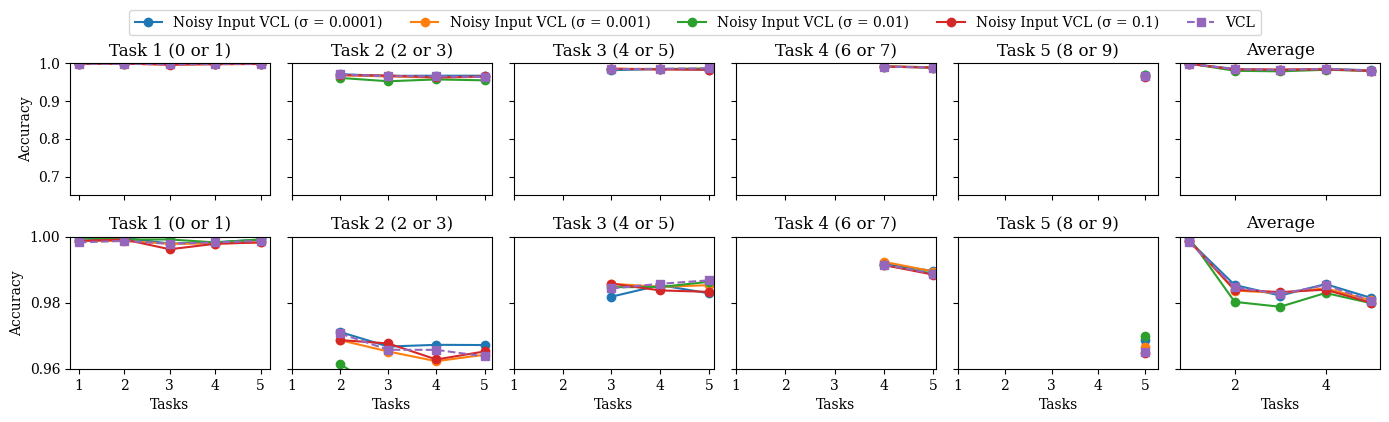

s_param


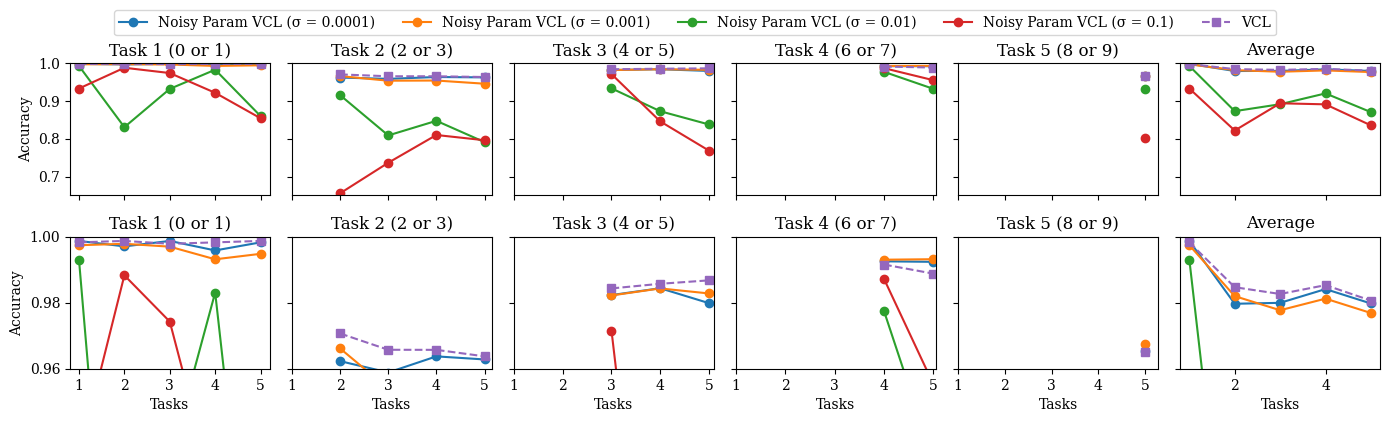

s_dropout


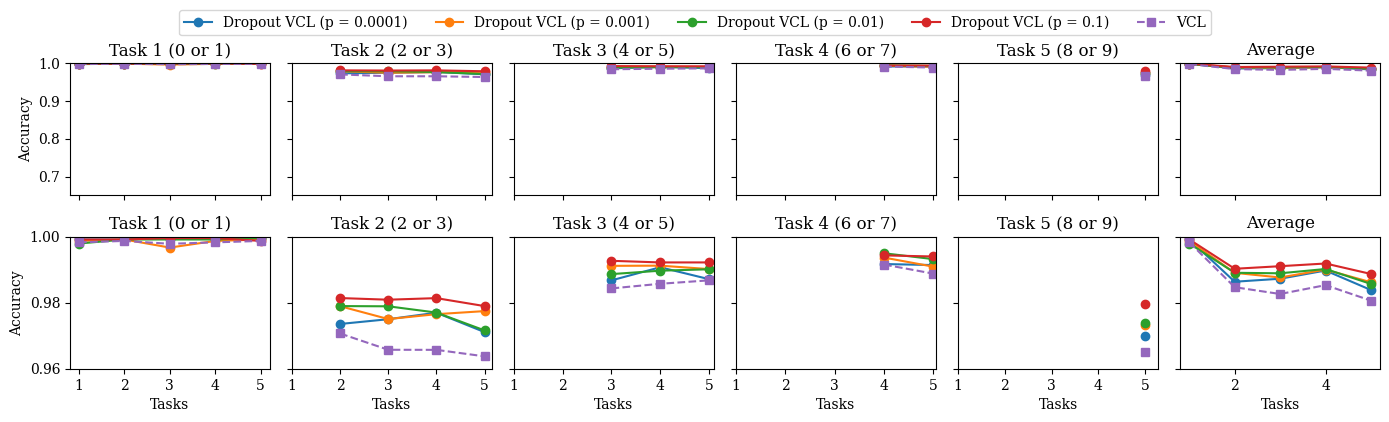

p_input


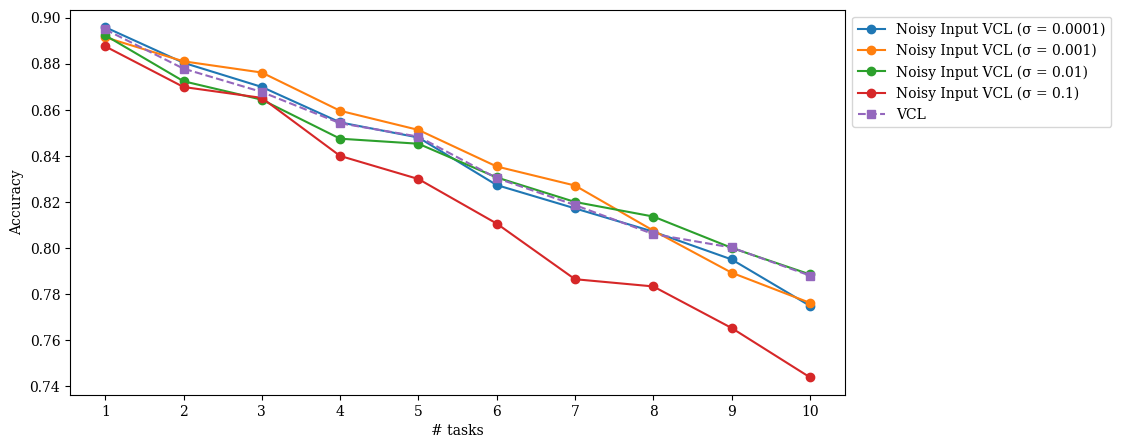

p_param


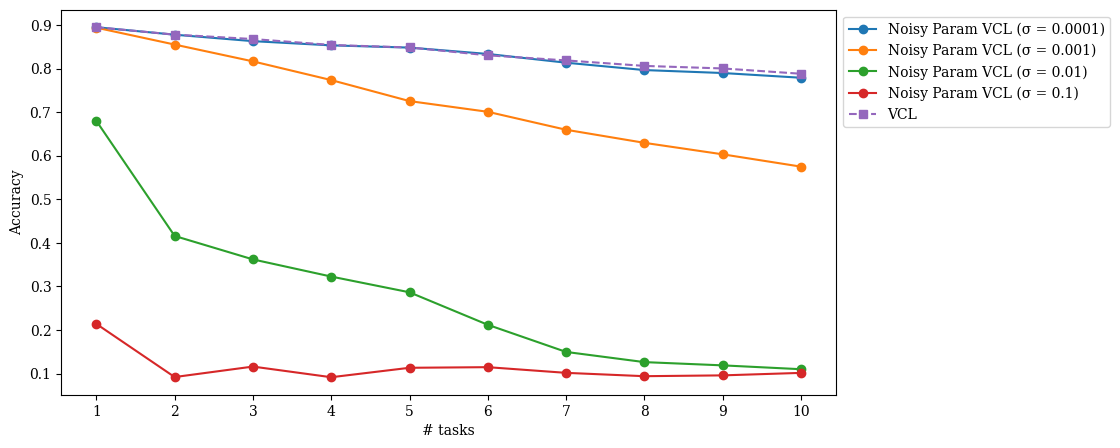

p_dropout


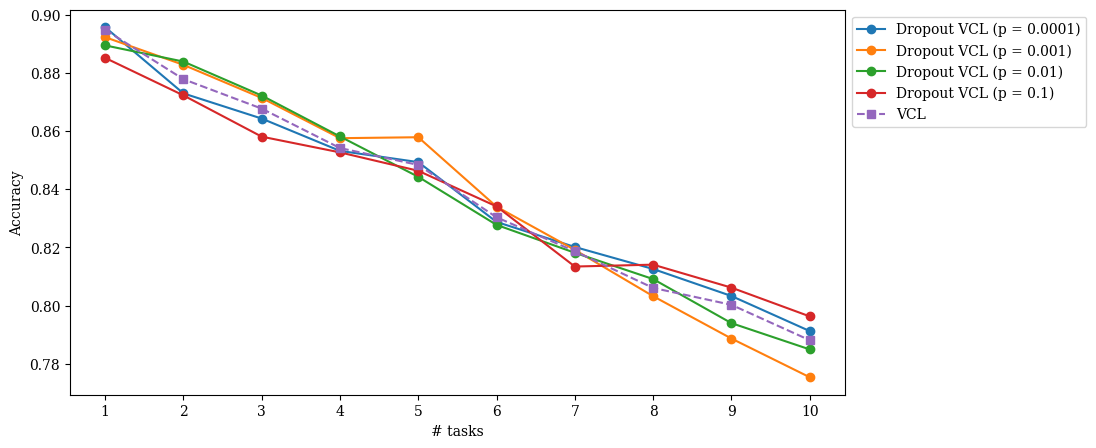

In [ ]:
# Plots of the results

import matplotlib.pyplot as plt

def average_task_accs(acc_matrix):
  return np.nanmean(acc_matrix, axis=1)


def plot_split_accs(filename, base_acc, exp_accs, exp_name_format, exp_params):
  print(filename)
  methods = []
  for i in range(len(exp_params)):
    methods.append(exp_name_format.format(exp_params[i]))
  methods.append('VCL')

  fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(14, 4))

  accs = exp_accs + [base_acc]
  x = np.arange(1, 6)
  tasks = ['(0 or 1)', '(2 or 3)', '(4 or 5)', '(6 or 7)', '(8 or 9)']

  # Loop over task columns
  for i in range(5):
    for j in range(len(methods)):

      if methods[j] == 'VCL':
        axs[0, i].plot(x, accs[j][:, i], label=methods[j], marker='s', linestyle='--')
        axs[1, i].plot(x, accs[j][:, i], label=methods[j], marker='s', linestyle='--')
      else:
        axs[0, i].plot(x, accs[j][:, i], label=methods[j], marker='o')
        axs[1, i].plot(x, accs[j][:, i], label=methods[j], marker='o')

    axs[0, i].set_title(f'Task {i+1} ' + tasks[i])
    axs[1, i].set_title(f'Task {i+1} ' + tasks[i])
    axs[0, i].set_xticks(x)
    axs[1, i].set_xticks(x)
    axs[0, i].set_ylim(0.65, 1)
    axs[1, i].set_ylim(0.96, 1)

  for ax in axs.flat:
    ax.set(xlabel='Tasks', ylabel='Accuracy')

  for ax in axs.flat:
    ax.label_outer()

  # Plot final average column separately
  for j in range(len(methods)):
    if methods[j] == 'VCL':
      axs[0, 5].plot(x, average_task_accs(accs[j]), label=methods[j], marker='s', linestyle='--')
      axs[1, 5].plot(x, average_task_accs(accs[j]), label=methods[j], marker='s', linestyle='--')
    else:
      axs[0, 5].plot(x, average_task_accs(accs[j]), label=methods[j], marker='o')
      axs[1, 5].plot(x, average_task_accs(accs[j]), label=methods[j], marker='o')
  axs[0, 5].set_title('Average')
  axs[1, 5].set_title('Average')
  axs[0, 5].set_ylim(0.65, 1)
  axs[1, 5].set_ylim(0.96, 1)

  # Legend
  handles, labels = axs[0, 0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=5)

  plt.tight_layout()
  plt.savefig(filename+'.png', dpi=300, bbox_inches='tight')
  plt.show()


def permuted_accs_y(base_acc, exp_accs, exp_name_format, exp_params):
  # Returns a dictionary of label to accuracies to plot
  y = {}

  for i in range(len(exp_accs)):
    y[exp_name_format.format(exp_params[i])] = average_task_accs(exp_accs[i])

  y['VCL'] = average_task_accs(base_acc)

  return y

def plot_permuted_accs(filename, base_acc, exp_accs, exp_name_format, exp_params):
  print(filename)
  plt.rc('font', family='serif')
  x = np.arange(1, 11)
  y = permuted_accs_y(base_acc, exp_accs, exp_name_format, exp_params)

  plt.figure(figsize=(10, 5))

  for method, acc in y.items():
    if method == 'VCL':
      plt.plot(x, acc, marker='s', linestyle='--', label=method)
    else:
      plt.plot(x, acc, marker='o', label=method)

  plt.xlabel('# tasks')
  plt.ylabel('Accuracy')
  plt.xticks(x)
  plt.legend(loc='upper left', bbox_to_anchor=(1,1))

  plt.savefig(filename+'.png', dpi=300, bbox_inches='tight')
  plt.show()



# Split MNIST Noisy Input
plot_split_accs("s_input", s_base_accs, s_input_accs, "Noisy Input VCL (σ = {})", input_std)

# Split MNIST Noisy Params
plot_split_accs("s_param", s_base_accs, s_param_accs, "Noisy Param VCL (σ = {})", param_std)

# Split MNIST Dropout
plot_split_accs("s_dropout", s_base_accs, s_dropout_accs, "Dropout VCL (p = {})", dropout_probs)



# Permuted MNIST Noisy Input
plot_permuted_accs("p_input", p_base_accs, p_input_accs, "Noisy Input VCL (σ = {})", input_std)

# Permuted MNIST Noisy Params
plot_permuted_accs("p_param", p_base_accs, p_param_accs, "Noisy Param VCL (σ = {})", param_std)

# Permuted MNIST Dropout
plot_permuted_accs("p_dropout", p_base_accs, p_dropout_accs, "Dropout VCL (p = {})", dropout_probs)
